<a href="https://colab.research.google.com/github/Prabhjot410/Implementation-of-Faster-Rcnn-from-scratch/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
od.download("https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prabhjot132
Your Kaggle Key: ··········


100%|██████████| 788M/788M [00:05<00:00, 141MB/s]


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device,torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)


cpu


(281, 300, 3)


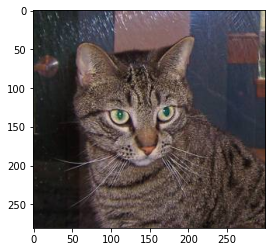

In [ ]:
# input image could be of any size
img0 = cv2.imread('/content/microsoft-catsvsdogs-dataset/PetImages/Cat/1.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
print(img0.shape)
plt.imshow(img0)
plt.show()

In [ ]:
#Object information
bbox0 = np.array([[50,50,200,200]]) #a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels 
labels = np.array([1,1]) #0:background,1:face

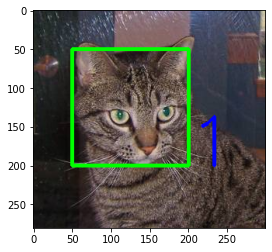

In [ ]:
# display bounding box and labels
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3) 
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img0_clone)
plt.show()    

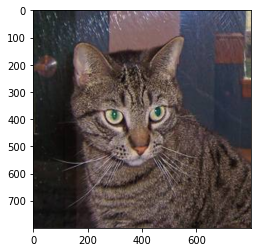

In [ ]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [ ]:
# change the bounding box coordinates 
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[142 133 569 533]]


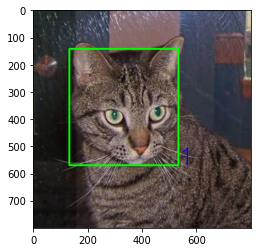

In [ ]:
# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=5) # Draw Rectangle
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_clone)
plt.show()  

In [ ]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [ ]:
# collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

torch.Size([1, 3, 800, 800])
30
512


In [ ]:
# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


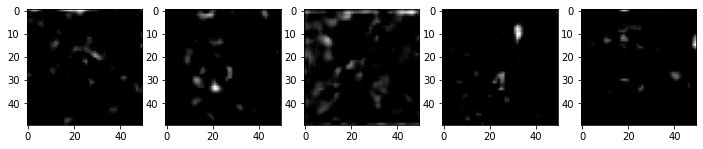

In [ ]:
# visualize the first 5 channels of the 50*50*512 feature maps
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5): 
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(imgArray[i], cmap='gray')
    figNo +=1
plt.show()

In [ ]:
# x, y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


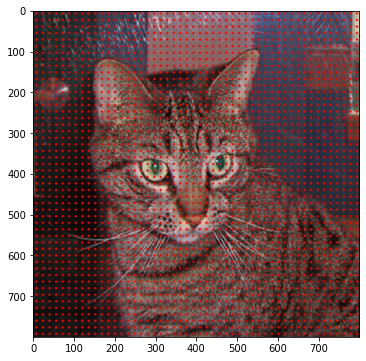

In [ ]:
# display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=3) 
plt.imshow(img_clone)
plt.show()  

In [ ]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


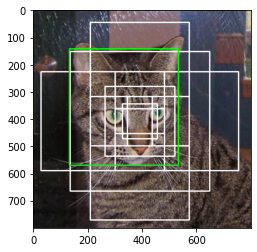

In [ ]:
# display the 9 anchor boxes of one anchor and the ground trugh bbox
img_clone = np.copy(img)
for i in range(11025, 11034):  #9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  

In [ ]:
# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1)>0 and (y2, x2)<=800
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [ ]:
# Calculate iou of the valid anchor boxes 
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8490, 2) as the output. 
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(8940, 2)


In [ ]:
# What anchor box has max iou with the ground truth bbox  
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[2536    0]
[0.6515503 0.       ]
[   0    1    2 ... 8937 8938 8939]


In [ ]:
# What ground truth bbox is associated with each anchor box 
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [ ]:
# Use iou to assign 1 (objects) to two kind of anchors 
# a) The anchors with the highest iou overlap with a ground-truth-box
# b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [ ]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - int(n_pos)), replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

In [ ]:
# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

# valid anchor boxes 的 h, w, cx, cy 
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

# valid anchor box 的 max iou 的 bbox 的 h, w, cx, cy 
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# valid anchor boxes 的 loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps) #讓 height !=0, 最小值為 eps
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [ ]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [ ]:
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
x = conv1(out_map.to(device)) # out_map = faster_rcnn_fe_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [ ]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [ ]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [ ]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [ ]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.7009, grad_fn=<NllLossBackward0>)


In [ ]:
#For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([128, 4]) torch.Size([128, 4])
tensor(36.2092, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(3.5298, dtype=torch.float64, grad_fn=<AddBackward0>)


In [ ]:
nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [ ]:
# The labelled 22500 anchor boxes 
# format converted from [y1, x1, y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4] #每個 anchor box 的 dy
dx = pred_anchor_locs_numpy[:, 1::4] # dx
dh = pred_anchor_locs_numpy[:, 2::4] # dh
dw = pred_anchor_locs_numpy[:, 3::4] # dw
print(dy.shape)
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500,)
(22500, 1)
(22500, 1)


In [ ]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

# clip the predicted boxes to the image
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4)
(22500, 4) 800.0 0.0


In [ ]:
# Remove predicted boxes with either height or width < threshold.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

# Sort all (proposal, score) pairs by score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order.shape)

#Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)

(22500,) (22500, 4) (22500,)
(22500,)
(12000,) (12000, 4) (12000, 4)


In [ ]:
# Take all the roi boxes [roi_array]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

# Find the areas of all the boxes [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
#Take the indexes of order the probability score in descending order 
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0] #take the 1st elt in order and append to keep 
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals
print(len(keep), roi.shape)

2000 (2000, 4)


In [ ]:
n_sample = 128  # Number of samples from roi 
pos_ratio = 0.25 # Number of positive examples out of the n_samples
pos_iou_thresh = 0.5  # Min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5  # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
# Find the iou of each ground truth object with the region proposals, 
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
            ious[num1, num2] = iou
print(ious.shape)

(2000, 2)


In [ ]:
# Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

# Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[1 1 1 ... 1 1 1]


In [ ]:
# Select the foreground rois as per the pos_iou_thesh and 
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.
pos_roi_per_image = 32 
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice( neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

0
[]
128
[1148  544  439 1919  611  438 1449   77 1726 1198  560 1492 1288   48
  125  559   17  266 1191  825  357  723 1746 1339  402  953  617 1838
  483 1307  230 1724 1030  277 1046 1352  414  547 1867 1125  592  441
 1349 1277 1110  502 1423  564  671  217 1518  308  252  397  934  928
  267 1699 1517  890 1956 1292 1852  780 1819 1081  268 1249  548  477
  423  752  931  516 1168  568  555 1915  892  567 1608  778 1150 1941
 1979 1015  104  306  905 1505 1146  371 1538 1775 1617  274 1631  107
  136  132 1205 1085  476  349 1052 1641  815  984 1897  377 1984   33
 1698 1275  255  452 1548 1513 1075  606  490 1144 1192 1649 1453 1204
  940  719]


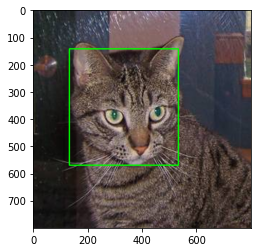

In [ ]:
# display ROI samples with postive 
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  

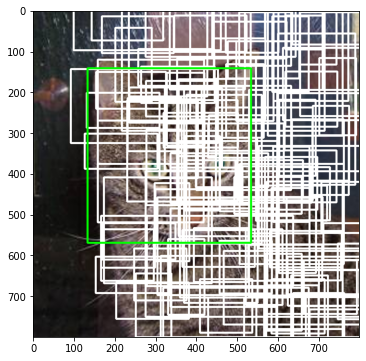

In [ ]:
# display ROI samples with negative 
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  

In [ ]:
# Now we gather positve samples index and negitive samples index, 
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and 
# later parameterize as we have done while assigning locations to anchor boxes in section 2.
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)
height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
(128, 4)


In [ ]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


In [ ]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [ ]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


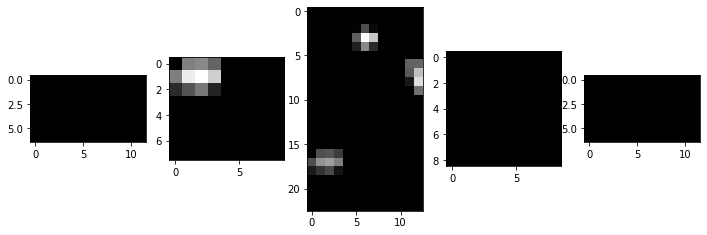

In [ ]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()

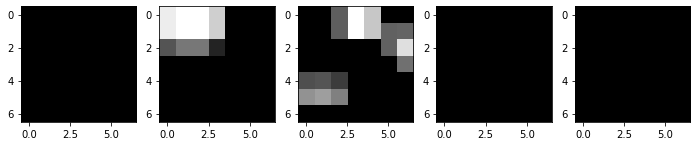

In [ ]:
# Visualize the first 5 ROI's feature maps after ROI pooling (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()

In [ ]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


In [ ]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()
score = nn.Linear(4096, 2).to(device)

In [ ]:
# passing the output of roi-pooling to ROI head 
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [ ]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:
gt_roi_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([])


In [ ]:
# Regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([0, 4]) torch.Size([0, 4])
tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

tensor([], size=(0, 4), dtype=torch.float64, grad_fn=<AddBackward0>)


In [ ]:
total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([], size=(0, 4), dtype=torch.float64, grad_fn=<AddBackward0>)
